In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified

In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

imgRootValOriginal = '../data/CompCars_sv_original_split/val'
imgRootValColor = '../data/CompCars_sv_color_split/val'
imgRootValWeb = '../data/CompCars_web_original_split/val'

annfileValOriginal = '../data/CompCars_sv_original_split/meta/val.txt'
annfileValColor = '../data/CompCars_sv_color_split/meta/val.txt'
annfileValWeb = '../data/CompCars_web_original_split/meta/val.txt'

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPath = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathNoScale = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'

camDataGradCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

In [3]:
b = get_blurred_dataset(cfgPath=configCAMResOG, imgRoot=imgRootVal, blurredSegments=['front_left_light', 'front_right_light'],
                       segData=segDataPathNoScale, saveImgs=True,
                       segConfig=configSeg, segCheckpoint=checkpointSeg, annfile=annfileValGt)

In [4]:
cfg = mmcv.Config.fromfile(configCAMResOG)
cfg.data.test['data_prefix'] = imgRootVal
cfg.data.test['ann_file'] = annfileValGt
cfg.data.test['type'] = 'Test'

cfg.data.test['imgRoot'] = imgRootVal
cfg.data.test['classes'] = [0,1,2,3,4,5,6]
cfg.data.test['blurredSegment'] = [0]
cfg.data.test['segData'] = segDataPath
build_dataset(cfg.data.test)

LEGO


<scripts.utils.BlurDataset.get_blur_dataset.<locals>.BlurDataset at 0x23267325630>

In [4]:
cfg.data.test

{'type': 'CompCars',
 'data_prefix': '../data/CompCars_sv_original_split/val',
 'ann_file': '../annfileValGt.txt',
 'pipeline': [{'type': 'LoadImageFromFile'},
  {'type': 'Resize', 'size': (256, -1)},
  {'type': 'CenterCrop', 'crop_size': 224},
  {'type': 'Normalize',
   'mean': [123.675, 116.28, 103.53],
   'std': [58.395, 57.12, 57.375],
   'to_rgb': True},
  {'type': 'ImageToTensor', 'keys': ['img']},
  {'type': 'Collect', 'keys': ['img']}]}

In [4]:
b[0]

{'img_metas': DataContainer({'filename': '../data/CompCars_sv_original_split/val\\Volkswagen_Magotan_f8a58c442b3c02.jpg', 'ori_filename': 'Volkswagen_Magotan_f8a58c442b3c02.jpg', 'ori_shape': (767, 744, 3), 'img_shape': (224, 224, 3), 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}),
 'img': tensor([[[-1.7925, -1.7925, -1.8268,  ..., -1.7069, -1.7069, -1.6898],
          [-1.7925, -1.7925, -1.8439,  ..., -1.7069, -1.7069, -1.6898],
          [-1.8439, -1.8097, -1.8097,  ..., -1.7069, -1.7412, -1.7240],
          ...,
          [-1.9124, -1.9295, -1.8782,  ..., -1.7240, -1.6898, -1.6898],
          [-1.9124, -1.9467, -1.8268,  ..., -1.6898, -1.7240, -1.6898],
          [-1.9295, -1.9467, -1.8439,  ..., -1.7240, -1.6727, -1.6555]],
 
         [[-1.6856, -1.6681, -1.7031,  ..., -1.5805, -1.5805, -1.5630],
          [-1.6856, -1.6506, -1.7206,  ..., -1.5805, -1.5805, -1.5455],
          [-1.

Compose(
    LoadImageFromFile(to_float32=False, color_type='color', file_client_args={'backend': 'disk'})
    Resize(size=(256, -1), interpolation=bilinear)
    CenterCrop(crop_size=(224, 224), efficientnet_style=False, crop_padding=32, interpolation=bilinear, backend=cv2)
    Normalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
    ImageToTensor(keys=['img'])
    Collect(keys=['img'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'flip', 'flip_direction', 'img_norm_cfg'))
)
Compose(
    LoadImageFromFile(to_float32=False,color_type='color',imdecode_backend='cv2')
)


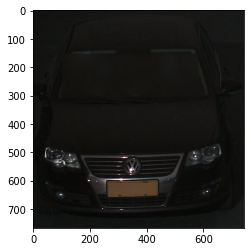

In [6]:
plt.imshow(b[0]['img'])

{'img_prefix': '../data/CompCars_sv_original_split/val', 'img_info': {'filename': 'Volkswagen_Magotan_f8a58c442b3c02.jpg'}, 'gt_label': array(254, dtype=int64), 'filename': '../data/CompCars_sv_original_split/val\\Volkswagen_Magotan_f8a58c442b3c02.jpg', 'ori_filename': 'Volkswagen_Magotan_f8a58c442b3c02.jpg', 'img': array([[[16, 17, 15],
        [16, 17, 15],
        [16, 17, 15],
        ...,
        [25, 25, 25],
        [26, 26, 26],
        [26, 26, 26]],

       [[16, 17, 15],
        [16, 17, 15],
        [16, 17, 15],
        ...,
        [25, 25, 25],
        [26, 26, 26],
        [26, 26, 26]],

       [[16, 17, 15],
        [16, 17, 15],
        [16, 17, 15],
        ...,
        [25, 25, 25],
        [26, 26, 26],
        [26, 26, 26]],

       ...,

       [[23, 25, 25],
        [22, 24, 24],
        [21, 23, 23],
        ...,
        [28, 30, 30],
        [26, 28, 28],
        [25, 27, 27]],

       [[23, 25, 25],
        [22, 24, 24],
        [21, 23, 23],
        ...,
  

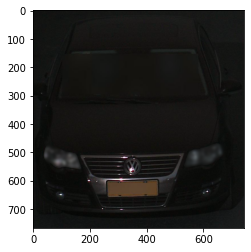

In [9]:
plt.imshow(b[0]['img'])